# Pytorch vanilla defense system
---
Translation from the Keras implementation into Pytorch. 
This code contains the Pytorch NNet used for predicting the distance to the sender given the GMM extracted features from the Constellation points.
(Thus, the originally proposed defensive system).

In [10]:
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

if not torch.cuda.is_available():
    raise Exception("You should enagle GPU in the Runtime menu")
device = torch.device("cuda")

In [2]:
# Chunk to mount Google Drive on Google Colab 

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# List with the users that will execute the code.
workers = ["Ronald", "Local"]

# Modify index to change the user.
worker = workers[0]

if worker == "Ronald":
  path= "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

In [4]:
# Reading the training data

data_path=path+"/trainingData"
file_name="training_data.csv"
df=pd.read_csv(data_path+'/'+file_name)
print(df.shape)
#print(df.head())

(625, 97)


In [5]:
# Formatting the training data.

colnames=df.columns[1:25]
# Target variable and train set
X=df.iloc[:,1:25]
#print(X.shape)
#print(X.columns)
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
#print(Y.shape)
#print(Y.columns)

#labels=[int(i) for i in df.iloc[:,0]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
X_train = sc_input.fit_transform(X)
Y_train = sc_output.fit_transform(Y)


X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

#print(X_train.shape)
#print(X_train.shape)
#print(Y_train.shape)
#print(colnames)
#print(labels)

In [6]:
# Creating the training dataset.

inputs  = torch.tensor(X_train)
targets = torch.tensor(Y_train)
    
dataset_train =TensorDataset(inputs, targets)

In [8]:
# Creating the NNet, training and test procedures.

class ann(nn.Module):

  def __init__(self,):
    super().__init__()

    self.linear1 = nn.Linear(in_features = 24,out_features = 12)
    self.linear2 = nn.Linear(in_features = 12,out_features = 6)
    self.linear3 = nn.Linear(in_features = 6,out_features = 1)
    self.tanh = nn.Tanh()

  def forward(self,x):

    out = self.tanh(self.linear1(x))
    out = self.tanh(self.linear2(out))
    out = self.linear3(out)

    return out 

def train(train_dl,model,optimizer,criterion,epochs):
  avg_loss = None
  avg_weight = 0.1
  losses = []
  for epoch in tqdm_notebook(range(1, epochs + 1)):
      for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear the gradients
        optimizer.zero_grad()
        # Model output
        y_ = model(inputs)
        # Loss 
        loss = criterion(y_,targets)
        loss.backward()
        optimizer.step()
        # Smooth the loss value that is saved to be plotted later
        if avg_loss:
          avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
          avg_loss = loss.item()
      losses.append(avg_loss)
      if not epoch%100:
        print("Epoch ",epoch,"/",epochs,""*10+"- loss: ", avg_loss, sep = "")
      


  plt.ylabel('Smoothed loss by factor {:.2f}'.format(1 - avg_weight))
  plt.xlabel('Iteration step')
  plt.plot(losses)

def test(test_dl,model,criterion):
  model.eval()
  avg_loss = None
  avg_weight = 0.1
  losses = []
  preds = []
  with torch.no_grad():
    for data, target in test_dl:
      data,target = data.to(device),target.to(device)
      y_ = model(data)
      preds.append(y_)
      loss = criterion(y_,target)
      if avg_loss:
          avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      losses.append(loss.item())
  print("Smoothed loss:",avg_loss)
  return losses,preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 100/5000- loss: 0.00029039435410537217
Epoch 200/5000- loss: 0.00036856802814937226
Epoch 300/5000- loss: 0.00032053427627687765
Epoch 400/5000- loss: 0.00028885620090948494
Epoch 500/5000- loss: 0.00025659647866063136
Epoch 600/5000- loss: 0.00027174238841130085
Epoch 700/5000- loss: 0.00022645462550723342
Epoch 800/5000- loss: 0.00025919501959276354
Epoch 900/5000- loss: 0.00015343876981932956
Epoch 1000/5000- loss: 0.0002620570512707394
Epoch 1100/5000- loss: 0.00018388678828080805
Epoch 1200/5000- loss: 0.0002039394160569858
Epoch 1300/5000- loss: 0.00014236696144441258
Epoch 1400/5000- loss: 0.00016263750610382663
Epoch 1500/5000- loss: 0.00017141819226912922
Epoch 1600/5000- loss: 0.0001385746025703686
Epoch 1700/5000- loss: 0.00017174204965924493
Epoch 1800/5000- loss: 0.00010617634838977967
Epoch 1900/5000- loss: 0.00015948155530572927
Epoch 2000/5000- loss: 0.00012216125295873143
Epoch 2100/5000- loss: 0.00016211980795269627
Epoch 2200/5000- loss: 0.00012079346421483056


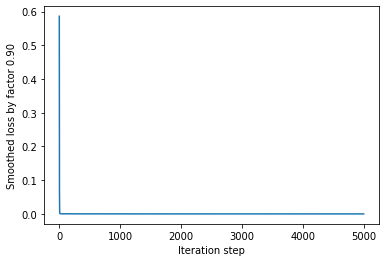

In [11]:
# Creating the model
model = ann()
model.to(device)

# Preparing data loaders and hyper.
train_dl = DataLoader(dataset_train,batch_size = 32, shuffle = True)
criterion = nn.MSELoss()
epochs = 5000
optimizer = optim.RMSprop(model.parameters(),lr = 0.001,eps = 1e-07,alpha = 0.9)

# Performing the training
start_time = time.time()
train(train_dl,model,optimizer,criterion,epochs)
time_train_ann = time.time() - start_time

In [12]:
# Reading the test data

data_path=path+"/trainingData"
file_name="testing_data.csv"
df=pd.read_csv(data_path+'/'+file_name)
print(df.shape)
#print(df.head())

(625, 97)


In [13]:
# Formatting the test data 

colnames=df.columns[1:25]
X=df.iloc[:,1:25]
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
X_test = sc_input.transform(X)
Y_test = sc_output.transform(Y)

X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)

inputs_test  = torch.tensor(X_test)
targets_test = torch.tensor(Y_test)
    
dataset_test =TensorDataset(inputs_test, targets_test)

Smoothed loss: 0.00025095432547569366


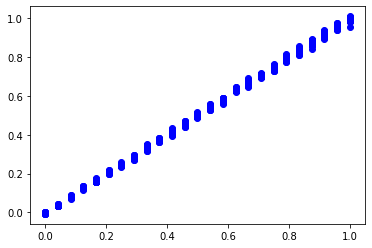

In [14]:
# Evaluating test results.

test_dl = DataLoader(dataset_test,batch_size = 1, shuffle = False)

start_time = time.time()
_, Y_test_pred =test(test_dl,model,criterion)
time_test_ann=time.time()-start_time

real=list(list(zip(*Y_test))[0])

#real=list(map(list, zip(*Y_train)))
pred=list(Y_test_pred)

plt.plot(real,pred,'bo')
plt.show()